In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from flash_attn import flash_attn_func

from library import StockUniverse, FactorLibrary, MarketInfo, FileLoader
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
import gc
import torch
from torch.utils.data import DataLoader
from library import FactorLibrary2
import gc
import xgboost as xgb
import pandas as pd
from xgboost import XGBRegressor
from kneed import KneeLocator



from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import f_regression
from kneed import KneeLocator
import pandas as pd


📂 讀取: Y:\因子回測_江建彰\因子庫.pkl


In [2]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import TimeSeriesSplit

In [3]:
stock_universe = 'TWSE'
flib = FactorLibrary2(path=f'Y:\因子回測_江建彰\因子庫{stock_universe}.pkl')

📂 讀取: Y:\因子回測_江建彰\因子庫TWSE.pkl


In [4]:
class AllDayFactorDataset(Dataset):
    def __init__(self, stock_universe='TWSE'):
        self.multi_df = FileLoader.load(f'Y:\因子回測_江建彰\因子庫{stock_universe}.pkl')
        self.adj_close_df = pd.read_feather(r'Y:\因子回測_江建彰\補上缺值日頻收盤價.ftr')
        self.stock_list = self.get_stock_list(stock_universe)
        
        self.TPEX_df = MarketInfo.TPEX_norm()
        self.RoR_df = (self.adj_close_df.shift(-5) - self.adj_close_df.shift(-1)) / self.adj_close_df.shift(-1)
        self.RoR_df.dropna(axis=0, inplace=True)


        new_ticker_list = self.multi_df.columns.get_level_values('ticker')
        new_ticker_list = new_ticker_list[~new_ticker_list.duplicated()]

        self.stock_list = new_ticker_list
        self.RoR_df = self.RoR_df[self.stock_list]
        self.adj_close_df = self.adj_close_df[self.stock_list]
        # 這裡所有值都包含當天資訊所以要向後移
        self.restrict_range()
        self.check_validility()

    def check_validility(self):
        ticker_list1 = self.stock_list
        ticker_list2 = self.RoR_df.columns
        ticker_list3 = self.multi_df.columns.get_level_values('ticker')
        ticker_list3 = ticker_list3[~ticker_list3.duplicated()]
        assert len(ticker_list1)==len(ticker_list2)==len(ticker_list3)
        
        BOOL = True
        for i in range(len(ticker_list1)):
            if not (ticker_list1[i]==ticker_list2[i]==ticker_list3[i]):
                BOOL = False
        assert BOOL==True
        

        factor_list = self.multi_df.columns.get_level_values('factor')
        factor_list = factor_list[~factor_list.duplicated()]
        BOOL = True
        for factor_name in factor_list:
            ticker_list4 = self.multi_df.loc[ : , factor_name].columns
            for i in range(len(ticker_list1)):
                if ticker_list1[i]!=ticker_list4[i]:
                    BOOL = False
        assert BOOL==True
        
    

    def restrict_range(self, global_start='2020-04-01', global_end='2025-04-09'):
        self.multi_df     = self.multi_df.loc[global_start : global_end]
        self.adj_close_df = self.adj_close_df.loc[global_start : global_end]
        self.TPEX_df      = self.TPEX_df.loc[global_start : global_end]
        self.RoR_df       = self.RoR_df.loc[global_start : global_end]
    
        
        
        
    def get_stock_list(self, stock_univserse):
        if stock_univserse=='TWSE':
            ticker1 = StockUniverse.TWSE() 
        elif stock_univserse=='OTC':
            ticker1 = StockUniverse.OTC()
        elif stock_univserse=='all':
            ticker1 = StockUniverse.all()
            
        
        ticker2 = self.multi_df.columns.get_level_values('ticker')
        ticker3 = self.adj_close_df.columns
        return list(set(ticker1)&set(ticker2)&set(ticker3))


    

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
factor_dataset = AllDayFactorDataset(stock_universe='TWSE')

⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl


In [6]:
no_colinear_ticker_list = ['factor_0', 'factor_1', 'factor_5', 'factor_8', 'factor_12',
       'factor_13', 'factor_16', 'factor_20', 'factor_27', 'factor_28',
       'factor_34', 'factor_35', 'factor_41', 'factor_45', 'factor_46',
       'factor_47', 'factor_51', 'factor_61', 'factor_62', 'factor_66',
       'factor_67', 'factor_69', 'factor_72', 'factor_76', 'factor_83',
       'factor_87', 'factor_88', 'factor_92', 'factor_93', 'factor_94',
       'factor_99', 'factor_102', 'factor_105', 'factor_106', 'factor_113',
       'factor_114', 'factor_116', 'factor_119', 'factor_120', 'factor_121',
       'factor_122', 'factor_123', 'factor_124', 'factor_125', 'factor_126',
       'factor_128', 'factor_129', 'factor_130', 'factor_132', 'factor_133',
       'factor_134', 'factor_137', 'factor_139', 'factor_140', 'factor_145',
       'factor_150', 'factor_154', 'factor_158', 'factor_162', 'factor_164',
       'factor_165', 'factor_167', 'factor_170', 'factor_172', 'factor_174',
       'factor_175', 'factor_176', 'factor_178', 'factor_179', 'factor_181',
       'factor_182', 'factor_183', 'factor_184', 'factor_185']


In [80]:
import re

numbers_only = [int(re.search(r'\d+', f).group()) for f in no_colinear_ticker_list]
print(numbers_only)


[0, 1, 5, 8, 12, 13, 16, 20, 27, 28, 34, 35, 41, 45, 46, 47, 51, 61, 62, 66, 67, 69, 72, 76, 83, 87, 88, 92, 93, 94, 99, 102, 105, 106, 113, 114, 116, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 132, 133, 134, 137, 139, 140, 145, 150, 154, 158, 162, 164, 165, 167, 170, 172, 174, 175, 176, 178, 179, 181, 182, 183, 184, 185]


In [81]:
len(numbers_only)

74

In [7]:
factor_dataset.multi_df = factor_dataset.multi_df[no_colinear_ticker_list]
factor_dataset.multi_df

factor      factor_0                                                    \
ticker          1101      1102      1103      1104      1108      1109   
Date                                                                     
2020-04-01 -0.673939 -0.455914 -0.600366 -0.193277  1.754857 -0.967506   
2020-04-06 -0.327203 -0.146773 -0.556454 -0.166725  1.027622 -0.758691   
2020-04-07  0.098016  1.224380  0.101407  0.234013  0.153450 -0.239635   
2020-04-08 -0.319991  0.674528  0.049169  0.289316 -0.621626 -0.291409   
2020-04-09 -0.232543  0.327937  0.066867  0.110226 -0.713421 -0.238935   
...              ...       ...       ...       ...       ...       ...   
2025-04-01  0.340768  0.900310  0.464735  0.591395  0.006090  0.103580   
2025-04-02  1.004445  0.171334 -0.185994  0.407952 -0.374743 -0.487857   
2025-04-07  1.361418  1.361418  1.182799  1.361418  1.356861  1.361418   
2025-04-08  1.427229  1.427229  1.427229  1.427229  1.427229  1.427229   
2025-04-09  1.450276  1.450276  1.450276  1.450276  1.450276  1.450276   

factor                                              ... factor_185            \
ticker          1110      1201      1203      1210  ...       9939      9940   
Date                                                ...                        
2020-04-01 -1.611826  1.346149 -0.139294  0.163777  ...   0.066802  0.072487   
2020-04-06 -2.130461 -0.347443 -1.021574 -0.870032  ...   0.082190  0.082626   
2020-04-07 -1.987577 -0.916866 -0.984516 -0.930563  ...   0.068940  0.073008   
2020-04-08 -1.360423 -0.868599 -0.781669 -0.766940  ...   0.055604  0.033972   
2020-04-09 -0.264998 -0.536980 -0.391901 -0.507913  ...   0.049386  0.022256   
...              ...       ...       ...       ...  ...        ...       ...   
2025-04-01  1.969913  0.432038  0.489601  0.704419  ...  -1.143642 -0.416881   
2025-04-02  1.728988  1.728988  1.096996  1.728988  ...  -0.992188  0.137274   
2025-04-07  1.361418  1.361418  1.361418  1.361418  ...  -0.008507  0.000583   
2025-04-08  1.427229  1.427229  1.427229  1.427229  ...  -0.027256 -0.034378   
2025-04-09  1.167629  1.378374  1.450276  1.450276  ...  -0.067628  0.004631   

factor                                                                  \
ticker          9941      9942      9943      9944      9945      9946   
Date                                                                     
2020-04-01  0.058731  0.070173  0.068826  0.072342  0.041585  0.107296   
2020-04-06  0.078126  0.092643  0.096279  0.101995  0.070161  0.119151   
2020-04-07  0.074640  0.075921  0.077645  0.111064  0.090337  0.051750   
2020-04-08  0.036535  0.031070  0.035563  0.098852  0.055969 -0.003307   
2020-04-09  0.040502  0.031352  0.046665  0.097971  0.031984  0.103135   
...              ...       ...       ...       ...       ...       ...   
2025-04-01 -0.168819  0.081369  0.144244  1.824791 -0.507640 -1.891102   
2025-04-02  1.358135  0.246138  0.452394  1.848424 -0.107221 -1.861662   
2025-04-07  0.073191  0.038328  0.005722  0.076073  0.036290  0.023162   
2025-04-08 -0.011736 -0.036078 -0.000374  0.047075  0.018541  0.000232   
2025-04-09 -0.126421 -0.091972 -0.039853 -0.126421 -0.023461 -0.007847   

factor                          
ticker          9955      9958  
Date                            
2020-04-01  0.074130  0.078821  
2020-04-06  0.100967  0.086217  
2020-04-07  0.089592  0.078324  
2020-04-08  0.017020  0.083563  
2020-04-09  0.003805  0.043055  
...              ...       ...  
2025-04-01  1.824791  0.835318  
2025-04-02  1.848424  1.022157  
2025-04-07  0.076073  0.074417  
2025-04-08  0.104005  0.104005  
2025-04-09  0.156484  0.178677  

[1220 rows x 65638 columns]

In [8]:
65638/887

74.0

In [9]:
import psutil

mem = psutil.virtual_memory()

total_MB = mem.total / 1024 / 1024
available_MB = mem.available / 1024 / 1024

print(f"✅ 系統總記憶體: {total_MB:.2f} MB")
print(f"🟢 當前可用記憶體: {available_MB:.2f} MB")


✅ 系統總記憶體: 65298.48 MB
🟢 當前可用記憶體: 51494.93 MB


In [10]:
def get_multidf_shift(n, multi_df):
    # 原始欄位
    old_columns = multi_df.columns
    
    # 重命名：把 factor 改成 factor_shift1
    new_columns = [(f"{fac}_shift{n}", tic) for fac, tic in old_columns]
    
    # 替換 columns
    multi_df.columns = pd.MultiIndex.from_tuples(new_columns, names=["factor", "ticker"])
    return multi_df.shift(n)

shift_multi_df_list = [get_multidf_shift(i, factor_dataset.multi_df.copy()) for i in range(0,9)]
all_multi_df = pd.concat(shift_multi_df_list, axis=1)
all_multi_df = all_multi_df.dropna(axis=0, how='any')

In [11]:
all_multi_df

factor     factor_0_shift0                                                    \
ticker                1101      1102      1103      1104      1108      1109   
Date                                                                           
2020-04-15        0.013958 -0.201672 -0.339740 -0.584696 -0.549632 -0.282272   
2020-04-16        0.034026  0.337675 -0.107776 -0.674801 -0.589977 -0.445789   
2020-04-17        0.378489 -0.099463 -0.494212 -0.707160 -1.345811 -0.533943   
2020-04-20        0.922095 -0.021827 -0.405039 -0.417830 -0.645849 -0.588843   
2020-04-21        0.327030 -1.084917 -0.440371 -0.226221 -0.522327 -0.407719   
...                    ...       ...       ...       ...       ...       ...   
2025-04-01        0.340768  0.900310  0.464735  0.591395  0.006090  0.103580   
2025-04-02        1.004445  0.171334 -0.185994  0.407952 -0.374743 -0.487857   
2025-04-07        1.361418  1.361418  1.182799  1.361418  1.356861  1.361418   
2025-04-08        1.427229  1.427229  1.427229  1.427229  1.427229  1.427229   
2025-04-09        1.450276  1.450276  1.450276  1.450276  1.450276  1.450276   

factor                                              ... factor_185_shift8  \
ticker          1110      1201      1203      1210  ...              9939   
Date                                                ...                     
2020-04-15 -1.546238 -0.109791 -0.737367  0.291556  ...          0.066802   
2020-04-16 -1.597296 -0.105350 -0.415152 -0.434878  ...          0.082190   
2020-04-17 -0.167658  1.729352  0.140102  0.019750  ...          0.068940   
2020-04-20 -1.197003  0.675610  1.284421  0.396054  ...          0.055604   
2020-04-21 -0.876101  0.524946  1.006333  0.173825  ...          0.049386   
...              ...       ...       ...       ...  ...               ...   
2025-04-01  1.969913  0.432038  0.489601  0.704419  ...         -0.023592   
2025-04-02  1.728988  1.728988  1.096996  1.728988  ...          0.041764   
2025-04-07  1.361418  1.361418  1.361418  1.361418  ...          1.214724   
2025-04-08  1.427229  1.427229  1.427229  1.427229  ...         -0.019540   
2025-04-09  1.167629  1.378374  1.450276  1.450276  ...          0.008608   

factor                                                                  \
ticker          9940      9941      9942      9943      9944      9945   
Date                                                                     
2020-04-15  0.072487  0.058731  0.070173  0.068826  0.072342  0.041585   
2020-04-16  0.082626  0.078126  0.092643  0.096279  0.101995  0.070161   
2020-04-17  0.073008  0.074640  0.075921  0.077645  0.111064  0.090337   
2020-04-20  0.033972  0.036535  0.031070  0.035563  0.098852  0.055969   
2020-04-21  0.022256  0.040502  0.031352  0.046665  0.097971  0.031984   
...              ...       ...       ...       ...       ...       ...   
2025-04-01  0.015413  0.022440  0.013471  0.030102  0.087417  0.021586   
2025-04-02  0.014625  0.090190  0.007788  0.030575  0.090190  0.021468   
2025-04-07 -0.504837  1.790602 -0.162964 -0.012348  1.790602 -0.743591   
2025-04-08 -0.718179  1.410096 -0.116553 -0.057551  1.743454 -0.690271   
2025-04-09  0.040786  0.090051  0.029571  0.028960  0.056549  0.010588   

factor                                    
ticker          9946      9955      9958  
Date                                      
2020-04-15  0.107296  0.074130  0.078821  
2020-04-16  0.119151  0.100967  0.086217  
2020-04-17  0.051750  0.089592  0.078324  
2020-04-20 -0.003307  0.017020  0.083563  
2020-04-21  0.103135  0.003805  0.043055  
...              ...       ...       ...  
2025-04-01  0.056166  0.076325  0.087417  
2025-04-02  0.090190  0.009687  0.090190  
2025-04-07  1.790602 -0.778897  0.310149  
2025-04-08 -1.667560 -1.494040  1.311837  
2025-04-09 -0.030180 -0.007714  0.068006  

[1212 rows x 590742 columns]

In [12]:
1212*0.8

969.6

In [84]:
(all_multi_df.loc['2020-04-15' : '2025-04-09']
         .stack(level='ticker', future_stack=True)
         .reset_index()
         .sort_values(by=['Date', 'ticker'])  # 顯式確保順序
         .drop(columns=['Date', 'ticker'])
    )

factor,factor_0_shift0,factor_1_shift0,factor_5_shift0,factor_8_shift0,factor_12_shift0,factor_13_shift0,factor_16_shift0,factor_20_shift0,factor_27_shift0,factor_28_shift0,...,factor_174_shift8,factor_175_shift8,factor_176_shift8,factor_178_shift8,factor_179_shift8,factor_181_shift8,factor_182_shift8,factor_183_shift8,factor_184_shift8,factor_185_shift8
0,0.013958,1.135203,1.174119,0.000000,0.000000,0.000000,1.168648,0.000000,0.000000,0.000000,...,0.140199,-0.888264,-1.089436,0.166667,0.166667,-1.108633,0.166667,0.090238,0.091955,0.076458
1,-0.201672,-0.350124,0.537934,0.000000,0.000000,0.000000,1.471139,0.000000,0.000000,0.000000,...,-0.880372,-1.054056,-1.089436,0.166667,0.166667,-1.108633,0.166667,0.072030,0.079605,0.045248
2,-0.339740,-0.699315,-0.468685,0.000000,0.000000,0.000000,-0.731437,0.000000,0.000000,0.000000,...,1.160770,0.067441,1.413421,0.166667,0.166667,1.375346,0.166667,0.086056,0.097495,0.080847
3,-0.584696,-1.273606,-0.191595,0.000000,0.000000,0.000000,1.092482,0.000000,0.000000,0.000000,...,1.160770,0.882422,0.804181,0.166667,0.166667,1.375346,0.166667,0.086823,0.094854,0.070121
4,-0.549632,-1.323156,-0.783332,0.000000,0.000000,0.000000,1.187751,0.000000,0.000000,0.000000,...,1.160770,1.861251,1.413421,0.166667,0.166667,1.375346,0.166667,0.107778,0.106298,0.073895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075039,-0.615998,-0.665086,-0.321606,-0.854870,-1.042193,-0.208619,-0.179946,0.227584,0.377851,-0.641845,...,0.925120,1.943406,1.309209,1.430575,1.682376,0.457561,1.735263,0.074187,0.080003,0.056549
1075040,0.893574,1.109722,0.964520,0.636865,0.547572,0.759274,0.103014,0.375745,0.668030,-0.142987,...,0.272369,0.142630,-0.920248,-0.406706,-0.861545,-0.149811,0.377554,0.007497,0.032655,0.010588
1075041,-1.079307,-0.934317,-0.797304,-1.064585,-1.158710,-0.874076,-0.941097,-0.761042,-1.177067,-0.585592,...,-0.380382,-0.063440,0.194481,0.832523,-0.861545,0.457561,-0.313322,-0.015883,0.053059,-0.030180
1075042,-0.858004,-0.710468,-0.510363,-0.656977,-0.669673,-0.435344,-0.328305,-0.298298,-0.554268,-0.171756,...,-1.663169,-1.293940,-1.477613,-1.026321,-0.861545,-1.343417,-1.004198,0.000111,0.026183,-0.007714


In [13]:
# ---------- 共用基底類別 ----------

class BaseFeatureSelector:
    def _knee_select(self, scores_sorted):
        x = list(range(len(scores_sorted)))
        y_score = scores_sorted.values
        kn = KneeLocator(x, y_score, curve="convex", direction="decreasing")
        elbow_idx = kn.knee if kn.knee is not None else 10  # fallback 預設選前10個
        return scores_sorted.iloc[:elbow_idx].index.tolist()

class FRegressionFeatureSelector(BaseFeatureSelector):
    def select(self, model, X, y):
        f_scores, _ = f_regression(X, y)
        scores = pd.Series(f_scores, index=X.columns).fillna(0)
        scores_sorted = scores.sort_values(ascending=False)
        return self._knee_select(scores_sorted)

# ---------- 模型訓練主類別 ----------

class XGBRegression:
    def __init__(self, X_train, X_val, y_train, feature_selector):
        self.X_train_full = X_train
        self.X_val_full = X_val
        self.y_train = y_train
        self.feature_selector = feature_selector

        # 若是 XGB 型特徵選擇器，需要先訓練模型
        pre_model = self._fit_model(X_train, y_train)

        # 特徵選擇
        self.top_features = self.feature_selector.select(pre_model, X_train, y_train)

        # 用選出的特徵重新訓練模型
        self.model = self._fit_model(X_train[self.top_features], y_train)

        # 計算驗證損失
        self.y_pred = self._get_pred()

    def _fit_model(self, X, y):
        model = XGBRegressor(
            tree_method="hist",
            device="cuda",
            n_estimators=100,
            learning_rate=0.05,
            max_depth=6,
            random_state=42
        )
        model.fit(X, y)
        return model

    def _get_pred(self):
        y_pred = self.model.predict(self.X_val_full[self.top_features])
        return y_pred

In [14]:
#RoR_df = factor_dataset.RoR_df
#z_return_df = (RoR_df - RoR_df.mean(axis=1).values[:, None]) / RoR_df.std(axis=1).values[:, None]

In [15]:
train_date_list = [('2020-04-16','2024-09-30'),('2020-07-01','2024-12-31')]
test_date_list = [('2024-10-01','2024-12-31'),('2025-01-01','2025-04-09')]

In [16]:
list_of_dfs = []

for idx in range(len(train_date_list)):
    train_start, train_end = train_date_list[idx]
    test_start, test_end   = test_date_list[idx]
    tv_stacked = (
        all_multi_df.loc[train_start : train_end]
         .stack(level='ticker', future_stack=True)
         .reset_index()
         .sort_values(by=['Date', 'ticker'])  # 顯式確保順序
         .drop(columns=['Date', 'ticker'])
    )
    
    
    test_stacked = (
        all_multi_df.loc[test_start : test_end]
         .stack(level='ticker', future_stack=True)
         .reset_index()
    )
    
    r_tv_stacked = (
        z_return_df.loc[train_start : train_end]
        .stack()  # 把欄位 symbol_id 變成列
        .reset_index()  # index 變成欄位
        .sort_values(by=['trade_date', 'symbol_id'])
    )
    r_tv_stacked.columns = ['trade_date', 'symbol_id', 'return']
    r_tv_array = r_tv_stacked['return'].values


    selector = FRegressionFeatureSelector()
    regressor = XGBRegression(X_train =  tv_stacked,
                              X_val = test_stacked.drop(columns=['Date', 'ticker']), 
                              y_train = r_tv_array, 
                              feature_selector = FRegressionFeatureSelector())
    y_pred = regressor.y_pred

    pred_df = test_stacked[['Date', 'ticker']].copy()
    pred_df['prediction'] = y_pred
    list_of_dfs.append(pred_df)
    #break
    
    

C:\Users\dctp2025\.conda\envs\dc1\Lib\site-packages\xgboost\core.py:729: UserWarning: [13:47:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


# 非常重要 !!!!!
# 訓練時不用shift(1)，因為對應的是(self.adj_close_df.shift(-5) - self.adj_close_df.shift(-1)) / self.adj_close_df.shift(-1)
# 但是回測時，需要shift(1)，不然會未來洩漏，所有因子都包含當日資訊
# 所以不可以用當日資訊去當日選股

In [17]:
all_preds = pd.concat(list_of_dfs, ignore_index=True)

In [18]:
all_preds = (all_preds
             .set_index(['Date', 'ticker'])
             .sort_index()
)
all_preds

factor             prediction
Date       ticker            
2024-10-01 1101     -0.012128
           1102      0.030547
           1103      0.008936
           1104     -0.027927
           1108     -0.034185
...                       ...
2025-04-09 9944      0.031847
           9945      0.011771
           9946     -0.048096
           9955     -0.025193
           9958      0.086491

[108214 rows x 1 columns]

In [21]:
shifted_all_preds = all_preds.groupby(level='ticker').shift(1).dropna()
shifted_all_preds

factor             prediction
Date       ticker            
2024-10-04 1101     -0.012128
           1102      0.030547
           1103      0.008936
           1104     -0.027927
           1108     -0.034185
...                       ...
2025-04-09 9944      0.029330
           9945      0.013825
           9946     -0.025410
           9955     -0.074672
           9958      0.063329

[107327 rows x 1 columns]

In [24]:
def get_what_to_buy(trade_date):
    df_today = all_preds.xs(trade_date, level='Date')
    top_30 = df_today['prediction'].nlargest(30).index
    bottom_30 = df_today['prediction'].nsmallest(30).index
    
    return top_30, bottom_30

def get_buy_sell_price(trade_date, top_30, bottom_30):
    adj_close_day_df = factor_dataset.adj_close_df.loc[trade_date]
    buy_price  = adj_close_day_df[top_30]
    sell_price = adj_close_day_df[bottom_30]
    return buy_price, sell_price
    

In [25]:
sorted_dates = all_preds.index.get_level_values('Date').unique().sort_values().tolist()
sorted_dates = sorted_dates[8:]

import matplotlib.pyplot as plt
buy_price = None
sell_price = None
last_ret = 0
return_list = []
for idx, trade_date in enumerate(sorted_dates):
    if idx%5==0:
        last_ret = return_list[-1] if idx>0 else 0
        top_30, bottom_30 = get_what_to_buy(trade_date)
        buy_price, sell_price = get_buy_sell_price(trade_date, top_30, bottom_30)
        return_list.append(last_ret)

    else:
        c_buy_price, c_sell_price = get_buy_sell_price(trade_date, top_30, bottom_30)

        r = 0.5*((c_buy_price-buy_price)/buy_price).mean() - 0.5*((c_sell_price-sell_price)/sell_price).mean() + last_ret

        return_list.append(r)


        
    
    
    



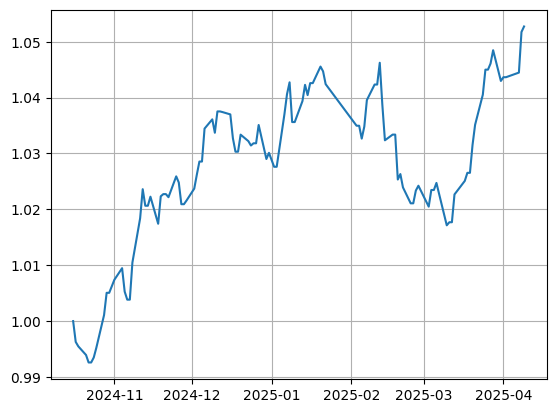

In [26]:
plt.plot(sorted_dates, 1+np.array(return_list))
#plt.title("累積報酬曲線")
#plt.xlabel("期數")
#plt.ylabel("累積報酬")
plt.grid(True)
plt.show()

In [33]:
(all_multi_df.loc['2020-04-15' : '2020-04-30']
     .stack(level='ticker', future_stack=True)
     .reset_index()
 #.set_index(['Date', 'ticker'])
# .sort_index()
     #.sort_values(by=['Date', 'ticker'])  # 顯式確保順序
     #.drop(columns=['Date', 'ticker'])
)

factor,Date,ticker,factor_0_shift0,factor_1_shift0,factor_5_shift0,factor_8_shift0,factor_12_shift0,factor_13_shift0,factor_16_shift0,factor_20_shift0,...,factor_174_shift8,factor_175_shift8,factor_176_shift8,factor_178_shift8,factor_179_shift8,factor_181_shift8,factor_182_shift8,factor_183_shift8,factor_184_shift8,factor_185_shift8
0,2020-04-15,1101,0.013958,1.135203,1.174119,0.0,0.0,0.0,1.168648,0.0,...,0.140199,-0.888264,-1.089436,0.166667,0.166667,-1.108633,0.166667,0.090238,0.091955,0.076458
1,2020-04-15,1102,-0.201672,-0.350124,0.537934,0.0,0.0,0.0,1.471139,0.0,...,-0.880372,-1.054056,-1.089436,0.166667,0.166667,-1.108633,0.166667,0.072030,0.079605,0.045248
2,2020-04-15,1103,-0.339740,-0.699315,-0.468685,0.0,0.0,0.0,-0.731437,0.0,...,1.160770,0.067441,1.413421,0.166667,0.166667,1.375346,0.166667,0.086056,0.097495,0.080847
3,2020-04-15,1104,-0.584696,-1.273606,-0.191595,0.0,0.0,0.0,1.092482,0.0,...,1.160770,0.882422,0.804181,0.166667,0.166667,1.375346,0.166667,0.086823,0.094854,0.070121
4,2020-04-15,1108,-0.549632,-1.323156,-0.783332,0.0,0.0,0.0,1.187751,0.0,...,1.160770,1.861251,1.413421,0.166667,0.166667,1.375346,0.166667,0.107778,0.106298,0.073895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10639,2020-04-30,9944,1.711314,0.719941,0.767027,0.0,0.0,0.0,0.282688,0.0,...,-0.185784,1.779684,0.655389,0.166667,1.849305,-1.037279,1.498599,0.090513,0.085552,0.068613
10640,2020-04-30,9945,-0.520805,-0.373476,-0.995006,0.0,0.0,0.0,-0.360680,0.0,...,-0.776951,-0.680616,0.134717,0.166667,-0.325062,-0.438771,-0.970950,0.064026,0.072371,0.053606
10641,2020-04-30,9946,-1.524104,-1.220058,-0.422156,0.0,0.0,0.0,-0.302559,0.0,...,-0.185784,-0.976341,-0.385954,0.166667,-1.058357,-1.037279,-0.970950,0.070309,0.066973,0.055406
10642,2020-04-30,9955,-1.285905,-1.104855,-0.747942,0.0,0.0,0.0,-0.781531,0.0,...,0.405383,1.937331,1.176060,0.166667,1.849305,1.335928,1.498599,0.056926,0.060973,0.044494


# Alphalens

In [72]:
import alphalens.tears as tears
from alphalens.utils import get_clean_factor

In [73]:
return_df_stacked = (factor_dataset.RoR_df
 .loc['2024-10-01':'2025-04-09']
 .stack(level='symbol_id', future_stack=True)
 .sort_index()
)
return_df_stacked.index.set_names(['date', 'asset'], inplace=True)
return_df_stacked.name = '5D'
return_df_stacked

date        asset
2024-10-01  1101    -0.038462
            1102    -0.034627
            1103    -0.011173
            1104    -0.004942
            1108    -0.030100
                       ...   
2025-04-09  9944    -0.006289
            9945     0.009331
            9946     0.038356
            9955     0.120507
            9958     0.204152
Name: 5D, Length: 108214, dtype: float64

In [74]:
all_preds.index.set_names(['date', 'asset'], inplace=True)
all_preds

factor            prediction
date       asset            
2024-10-01 1101    -0.012128
           1102     0.030547
           1103     0.008936
           1104    -0.027927
           1108    -0.034185
...                      ...
2025-04-09 9944     0.031847
           9945     0.011771
           9946    -0.048096
           9955    -0.025193
           9958     0.086491

[108214 rows x 1 columns]

In [75]:
all_preds['prediction']

date        asset
2024-10-01  1101    -0.012128
            1102     0.030547
            1103     0.008936
            1104    -0.027927
            1108    -0.034185
                       ...   
2025-04-09  9944     0.031847
            9945     0.011771
            9946    -0.048096
            9955    -0.025193
            9958     0.086491
Name: factor, Length: 108214, dtype: float32

In [76]:
all_preds['prediction'].name = 'factor'
factor_data = get_clean_factor(
    factor=all_preds['prediction'] ,
    forward_returns=return_df_stacked.to_frame(),  # 必須是 DataFrame
    quantiles=10  # 可調整分層數
)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [77]:
ic_series = factor_data.groupby(level='date').apply(
    lambda df: df['factor'].corr(df['5D'], method='spearman')
)

from scipy.stats import ttest_1samp, skew, kurtosis

ic_valid = ic_series.dropna()
ic_mean = ic_valid.mean()       # 例如 ≈ 0.049
ic_std = ic_valid.std()         # 例如 ≈ 0.102

risk_adjusted_ic = ic_mean / ic_std  # ≈ 0.049 / 0.102 ≈ 0.482


print("IC Mean", round(ic_mean, 3))
print("IC Std.", round(ic_std, 3))
print("Risk Adjusted IC", round(risk_adjusted_ic, 3))
print("t-stat(IC):", ttest_1samp(ic_valid, 0).statistic)
print("p-value(IC):", ttest_1samp(ic_valid, 0).pvalue)
print("IC skew:", skew(ic_valid))
print("IC kurtosis:", kurtosis(ic_valid))

IC Mean 0.006
IC Std. 0.057
Risk Adjusted IC 0.107
t-stat(IC): 1.176853514584473
p-value(IC): 0.24156386579178457
IC skew: -0.4103545254506106
IC kurtosis: 0.410805746913415


In [ ]:
tears.create_full_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.488106,-0.035565,-0.070398,0.031854,10858,10.033822
2,-0.066636,-0.025267,-0.043572,0.008014,10859,10.034746
3,-0.048151,-0.018463,-0.031803,0.005543,10736,9.921082
4,-0.035340,-0.010343,-0.022207,0.004887,10857,10.032898
5,-0.025591,-0.000884,-0.012726,0.004890,10858,10.033822
6,-0.017202,0.010341,-0.003596,0.004758,10736,9.921082
7,-0.008142,0.028450,0.006798,0.005964,10859,10.034746
8,0.000648,0.048919,0.020935,0.007842,10735,9.920158
9,0.016693,0.076968,0.041344,0.010886,10858,10.033822


Returns Analysis


,5D
Ann. alpha,0.037
beta,-0.022
Mean Period Wise Return Top Quantile (bps),15.255
Mean Period Wise Return Bottom Quantile (bps),-16.994
Mean Period Wise Spread (bps),32.249


C:\Users\dctp2025\.conda\envs\dc1\Lib\site-packages\alphalens\tears.py:262: UserWarning: 'freq' not set in factor_data index: assuming business day
  warnings.warn(


<Figure size 640x480 with 0 Axes>

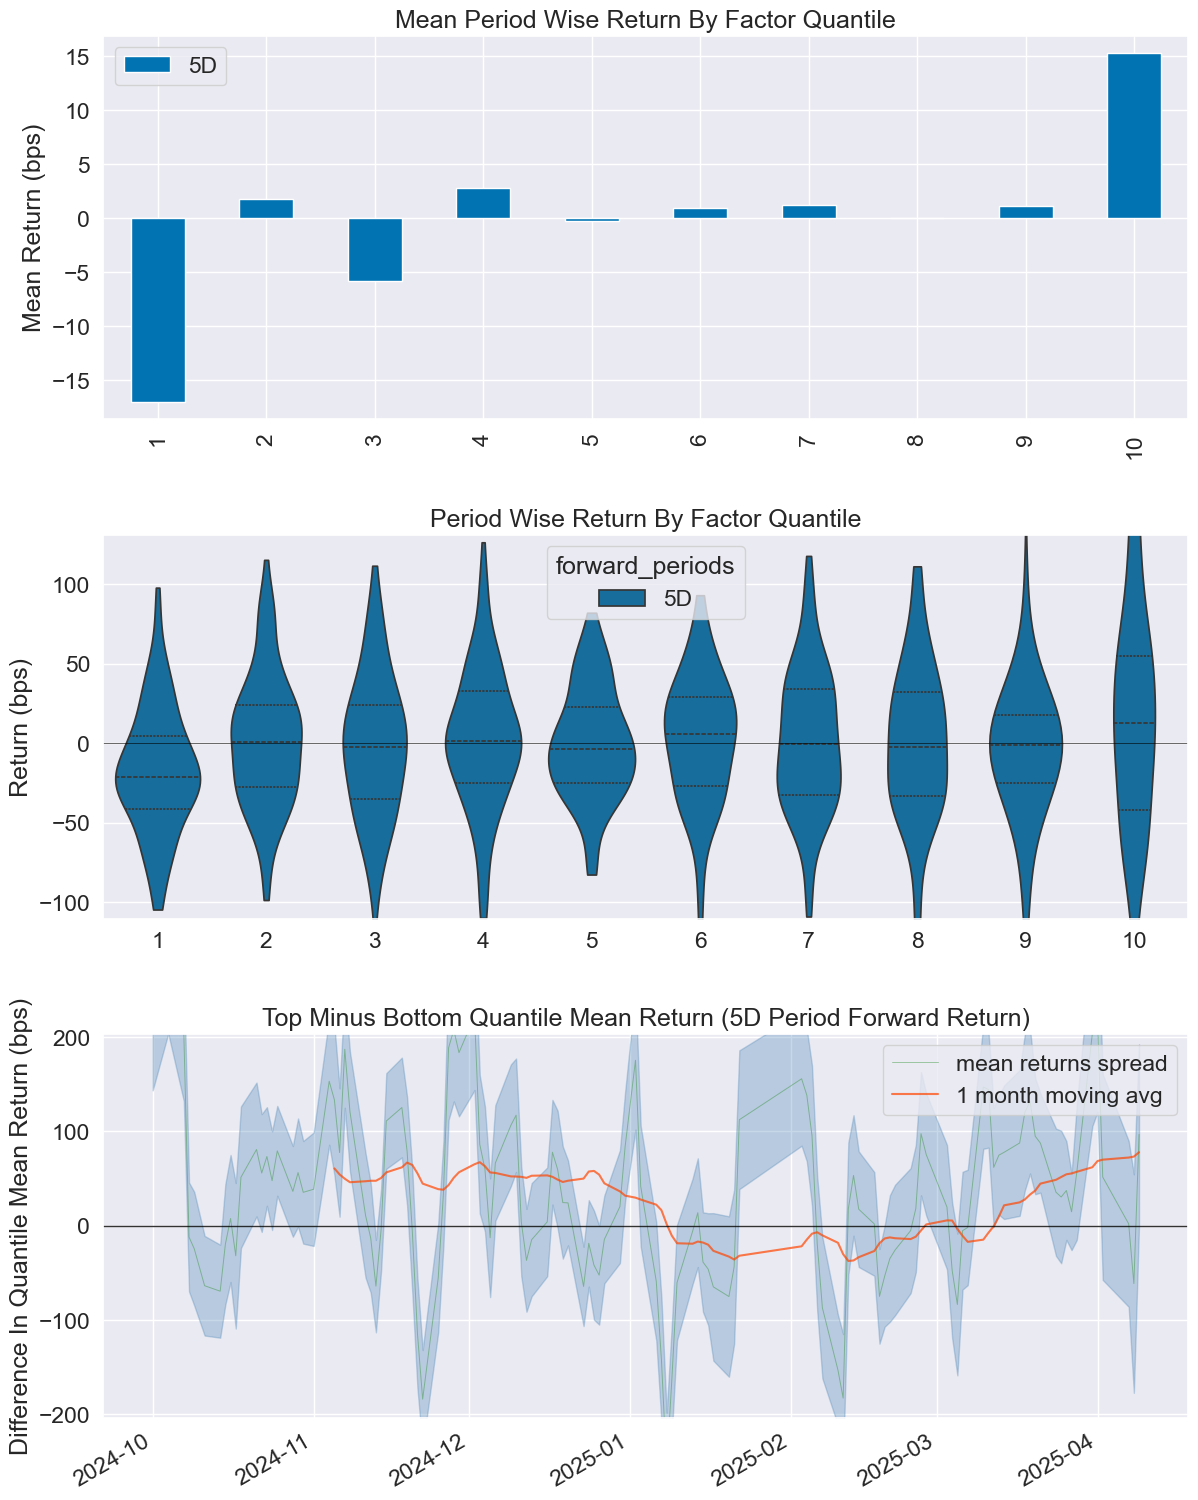

Information Analysis


,5D
IC Mean,0.006
IC Std.,0.057
Risk-Adjusted IC,0.107
t-stat(IC),NaN
p-value(IC),NaN
IC Skew,NaN
IC Kurtosis,NaN


C:\Users\dctp2025\.conda\envs\dc1\Lib\site-packages\alphalens\performance.py:118: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouper.append(pd.Grouper(freq=by_time))


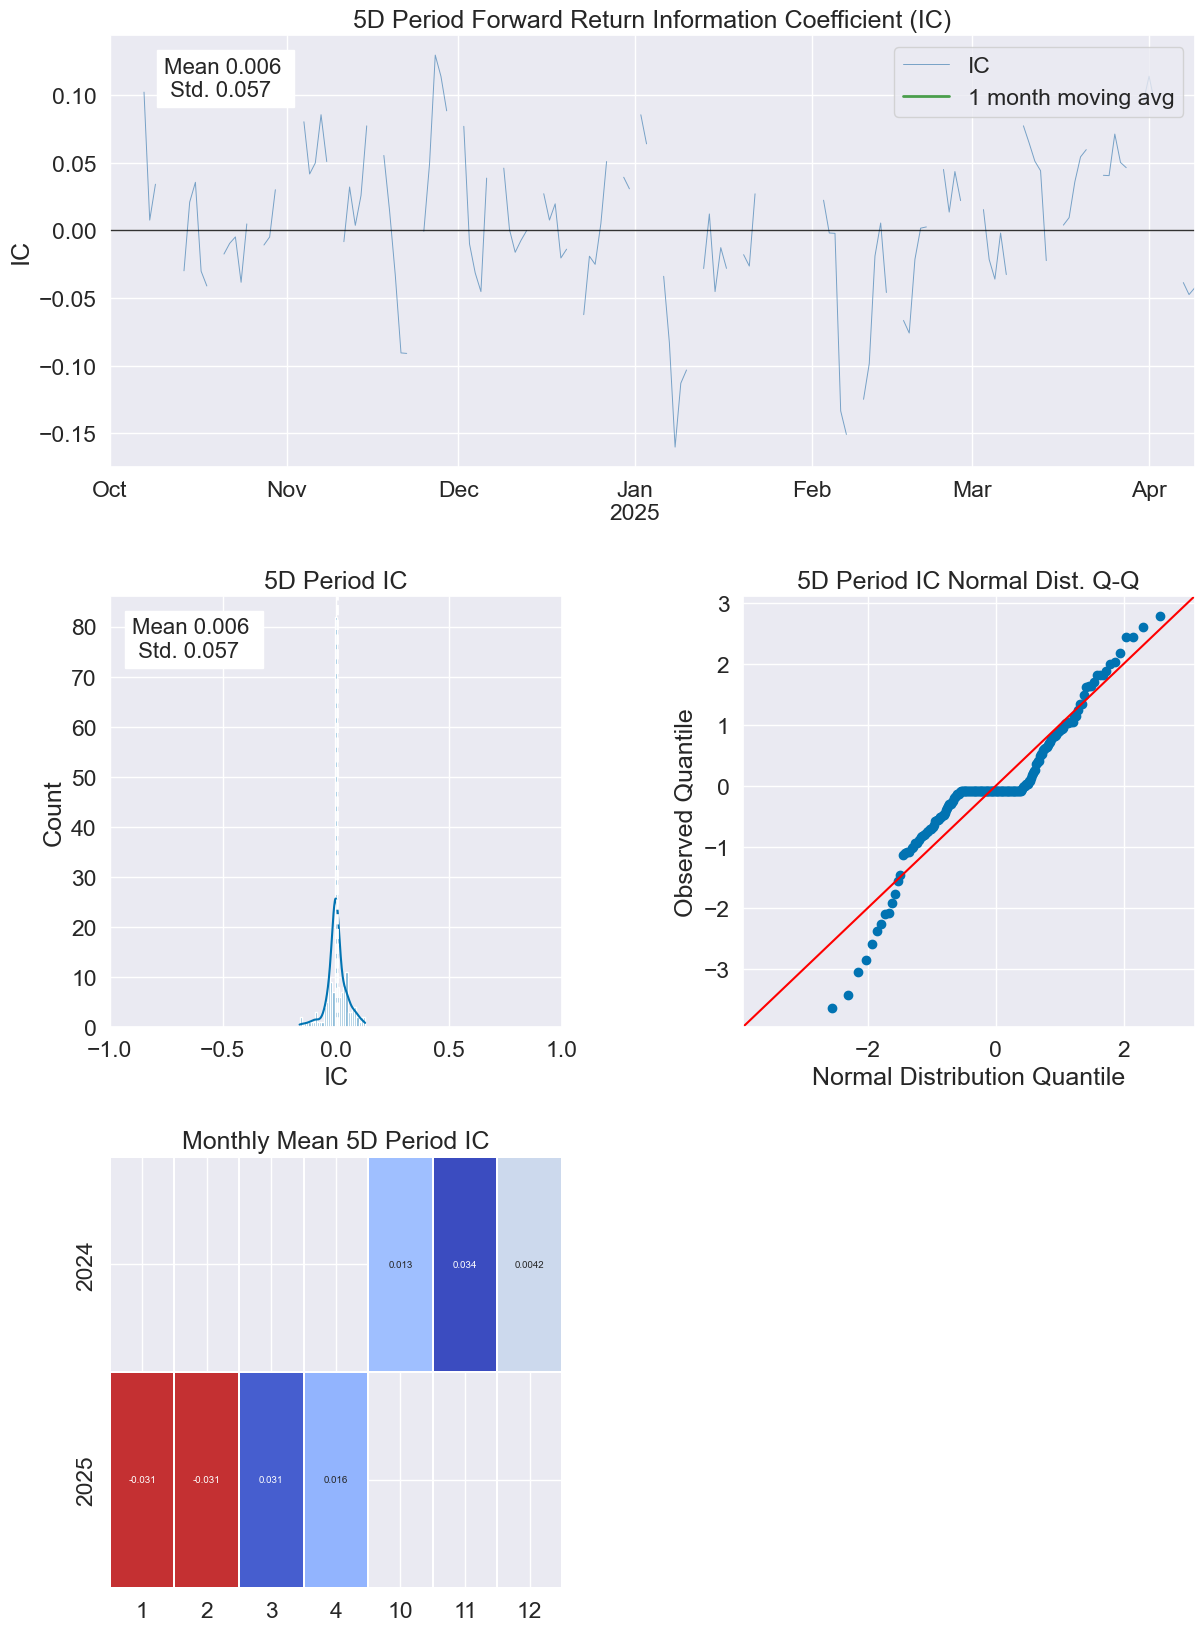

Turnover Analysis


C:\Users\dctp2025\.conda\envs\dc1\Lib\site-packages\alphalens\utils.py:928: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


,5D
Quantile 1 Mean Turnover,0.366
Quantile 2 Mean Turnover,0.468
Quantile 3 Mean Turnover,0.513
Quantile 4 Mean Turnover,0.540
Quantile 5 Mean Turnover,0.551
Quantile 6 Mean Turnover,0.553
Quantile 7 Mean Turnover,0.539
Quantile 8 Mean Turnover,0.539
Quantile 9 Mean Turnover,0.454
Quantile 10 Mean Turnover,0.296


,5D
Mean Factor Rank Autocorrelation,0.794


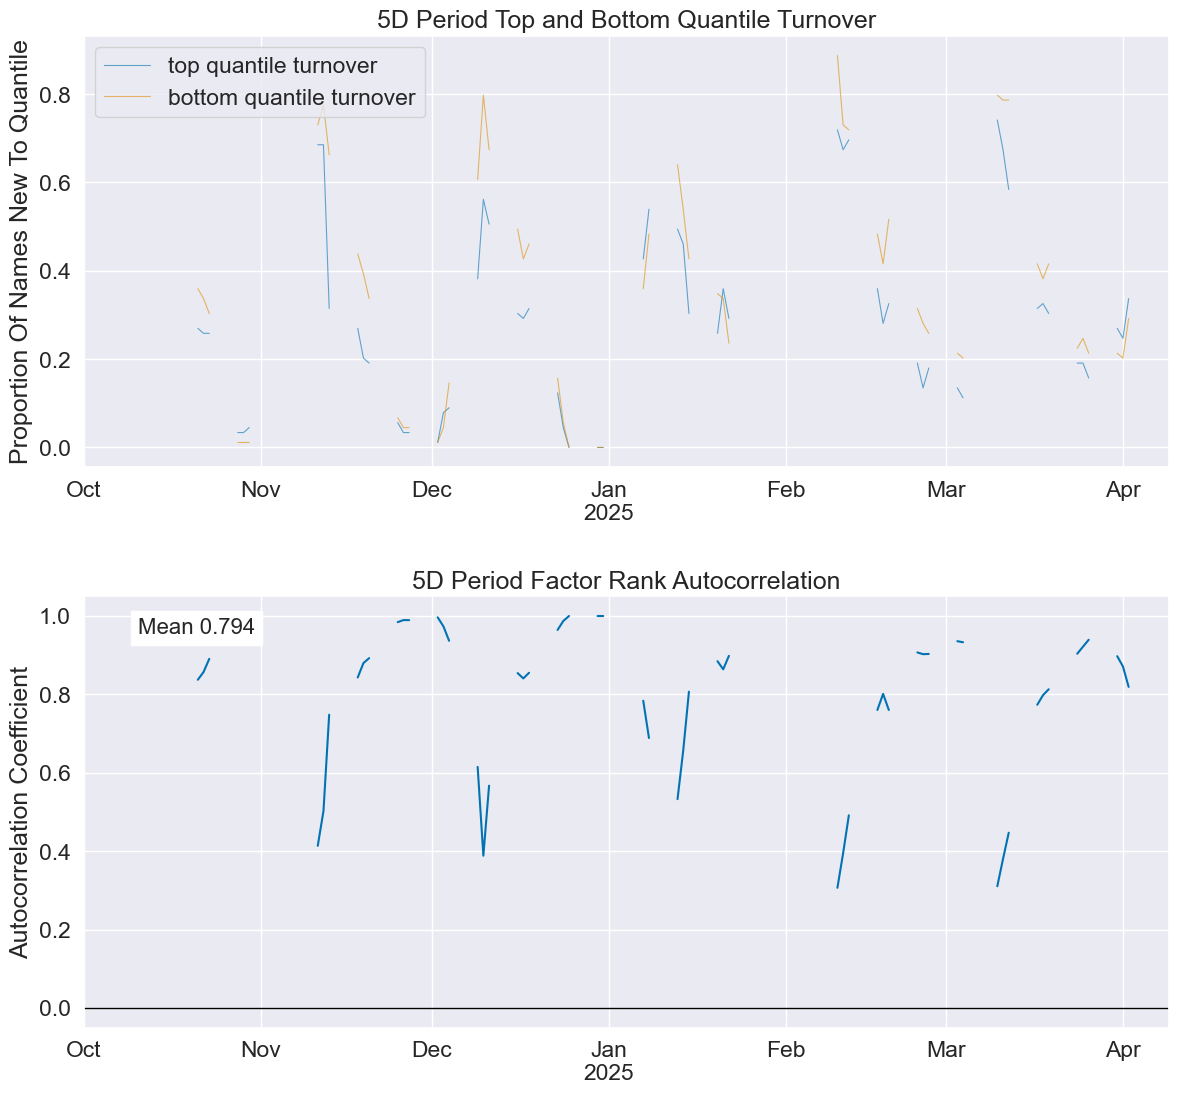

# Quantile

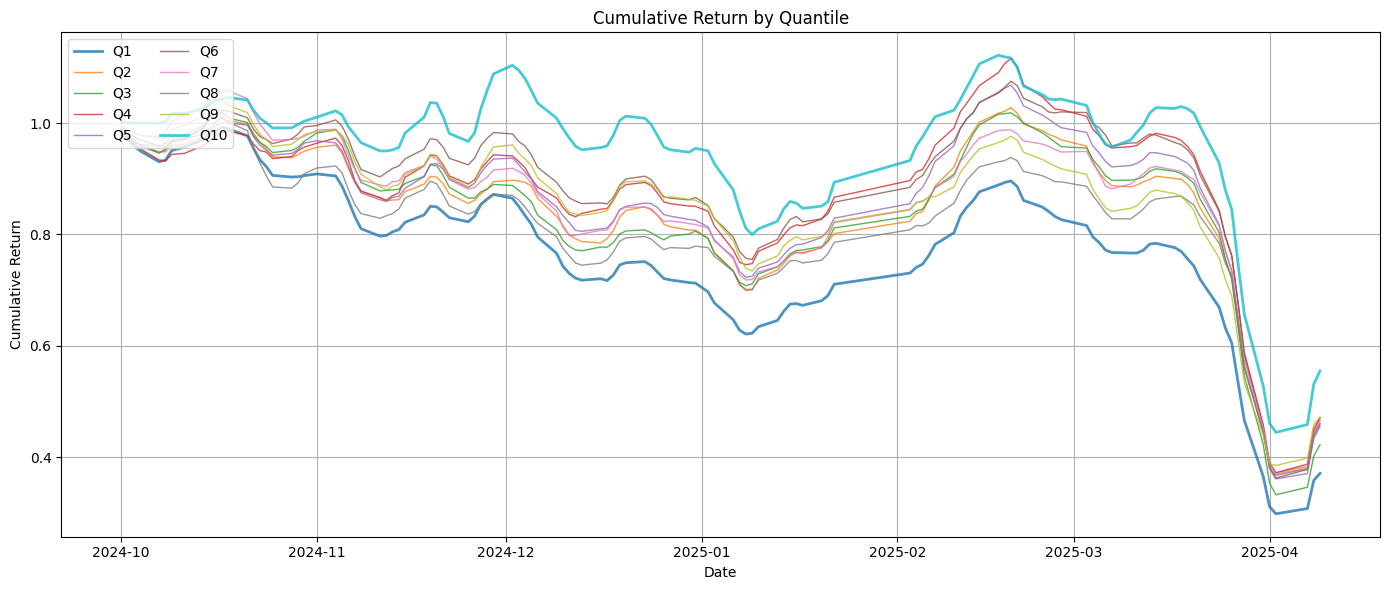

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 設定 quantile 數量
num_quantiles = 10

# 將 prediction 和 return 合併成一個 DataFrame
df = pd.concat([all_preds['prediction'], return_df_stacked], axis=1)
df.columns = ['prediction', 'return']

# 丟掉 NA
df = df.dropna()

# 為每一天依照 prediction 分 quantile
df['quantile'] = df.groupby('date')['prediction'].transform(
    lambda x: pd.qcut(x, q=num_quantiles, labels=False, duplicates='drop') + 1  # Q1~Q10 = 1~10
)

# 計算每個 quantile 每天的平均報酬
quantile_returns = df.groupby(['date', 'quantile'])['return'].mean().unstack()

# 計算每層累積報酬
quantile_cum_returns = (1 + quantile_returns).cumprod()

# 畫圖
plt.figure(figsize=(14, 6))
for q in quantile_cum_returns.columns:
    plt.plot(quantile_cum_returns.index, quantile_cum_returns[q],
             label=f'Q{q}', linewidth=2 if q in [1, num_quantiles] else 1, alpha=0.8)

plt.title("Cumulative Return by Quantile")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
